## Geodata Mask Module Sample Scripts

#### Jeffrey Feng (j1feng@ucsd.edu), July 2021

# Introduction

Geodata is also able to process raster files and geospatial shapefiles. Built off the Rasterio library, its mask module function includes adding shapefiles into binary mask layers, merging and flattening multiple raster images together, and extract region data from merged mask and shapefiles.

Its current functionalities in details are:

- Creating mask, adding layers from .tif files

- CRS convertion, cropping, trimming, binarizing layers

- Merging and flattening layers

- Adding .shp files as layers

- Extracting shapes from merged mask

In [1]:
import geodata
import numpy as np
import logging
logging.basicConfig(level=logging.INFO)
show = geodata.Mask.show

`import geodata` is required to use **geodata**, while launching a logger allows for detailed debugging via the console.

On the other hand, `import numpy as np` and `show = geodata.Mask.show` are not required. They are only the dependency for this demo, and the jupyter notebook example. We defined the show method as the Mask.show class method so that it is simple to call this visualization method it with one word.

Since this module process raster files, we would use the four following files:
    
- Elevation_Slope.tif
- FINAL_GRID_5BINS.tif
- FINAL_GRID_FOREST_MED.tif
- MODIS_China.tif

These tif files can be downloaded in https://drive.google.com/drive/u/1/folders/1uRnVkzZdY2SU3pzU8TiygBUVBMhxrvaJ

In [4]:
#These can be relative path if you downloaded these files in the same folder as this notebook
slope_path = 'elevation_slope.tif' #CHANGE IT
grid_bins_path = 'FINAL_GRID_5BINS.tif' #CHANGE IT
forest_med_path = 'FINAL_GRID_FOREST_MED.tif' #CHANGE IT
modis_china_path = 'MODIS_China.tif' #CHANGE IT

## CREATING OBJECT, ADDING LAYERS

The four methods below perform same functions. A user may add a layer to the Mask by specifying paths when a new instance is created, or use the `add_layer` method.

We wil add the following two files: `FINAL_GRID_5BINS.tif`, and `FINAL_GRID_FOREST_MED.tif` to the `China` Mask, and name them `bins` and `forest` layers.

In [5]:
china = geodata.Mask("China", layer_path = grid_bins_path)
china.rename_layer('FINAL_GRID_5BINS', 'bins')
china.add_layer(forest_med_path, layer_name = 'forest')

INFO:geodata.mask:Layer FINAL_GRID_5BINS added to the mask China.
INFO:geodata.mask:Layer forest added to the mask China.


In [6]:
china = geodata.Mask("China")
china.add_layer(layer_path = {'bins': grid_bins_path, 
                             'forest': forest_med_path})

INFO:geodata.mask:Layer bins added to the mask China.
INFO:geodata.mask:Layer forest added to the mask China.


In [7]:
china = geodata.Mask("China", layer_path = [grid_bins_path, forest_med_path], 
             layer_name = ['bins', 'forest'])

INFO:geodata.mask:Layer bins added to the mask China.
INFO:geodata.mask:Layer forest added to the mask China.


In [8]:
china = geodata.Mask("China", layer_path = {'bins': grid_bins_path, 
                              'forest': forest_med_path})

INFO:geodata.mask:Layer bins added to the mask China.
INFO:geodata.mask:Layer forest added to the mask China.


In [9]:
china

Mask China: 
2 layers: ['bins', 'forest'] .
No merged_mask ready. 
No shape has been extracted. 
Mask has not been saved/updated. 

About the `china` mask we created:

Each Mask object have an attribute `layers`, which is a dictionary of name: rasterio file opener. The <\open DatasetReader> can be the input for many other mask methods for the module.  

[FYI: not important for its usage]:

Although we save an openning layer in Rasterio, which only reads/opens/writes data on disk, sometimes we may have in-memory tif files in the `layers` attributes. This is because we might create a new layer after automatic CRS convertion if we detect that the input file is not in latitude-longitude CRS, or create a merged layer. In rasterio, a CRS convertion, merging-flattening, shapes on raster, cropping, and many other methods that make changes to the raster will requires creating a new file on disk, but we can avoid creating too many temporarily files and deleting them later by using memory files. Read more here: https://rasterio.readthedocs.io/en/latest/topics/memory-files.html

The other attributes are:

`merged_mask`: the merged and flatten mask of its layers, will be explained later

`shape_mask`: similar to the `layers` attribute, but a dictionary of extracted shapes from the merged mask.

`saved`: whether this mask object is saved locally.

`mask_dir`: the directory to save the mask object, by default it should be the path in config.py



Let us finish adding all the layers: add another layers `Elevation_Slope.tif` as `slope`.

In [10]:
china.add_layer(slope_path, layer_name = 'slope')

INFO:geodata.mask:Layer slope added to the mask China.


Some useful methods for the layers:

Get resolution

In [11]:
china.get_res()

{'bins': (0.008333333767950531, 0.00833333376795053),
 'forest': (0.0083333333000013, 0.0083333333000013),
 'slope': (0.008983152841195215, 0.008983152841195215)}

If we want to compare the area of the grid cell, so we know which layer has the smallest unit in term of product of coordinate difference of latitude and longitude. Note: it is not area of grid cells.

In [12]:
china.get_res(product = True)

{'bins': 6.944445168806459e-05,
 'forest': 6.944444388891055e-05,
 'slope': 8.069703496827367e-05}

Get bounds

In [13]:
china.get_bounds()

{'bins': BoundingBox(left=73.99999785762012, bottom=17.991666954917314, right=135.33333438973602, top=54.00000216623155),
 'forest': BoundingBox(left=73.99999785762012, bottom=17.991666954917314, right=135.33333094562968, top=54.00000014422293),
 'slope': BoundingBox(left=72.99253346658085, bottom=17.994777314571174, right=136.0003674947241, top=58.23031889028454)}

### CRS convertion, trimming, cropping (if necessary)

Method `open_tif` can open a layer without adding it to the layer, this allows us to visualize it before-hand.

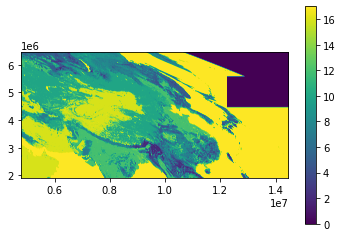

INFO:geodata.mask:Please remember to close the file with .close()


<open DatasetReader name='MODIS_China.tif' mode='r'>

In [14]:
china.open_tif(modis_china_path, show=True)

The `add_layer` method incorporate CRS convertion, let us see what the layer look like after we add it to the object.

In [15]:
china.add_layer(modis_china_path, layer_name = 'modis')

INFO:geodata.mask:Raster MODIS_China.tif has been reprojected to lat-lon CRS.
INFO:geodata.mask:Layer modis added to the mask China.


Note that now the `show` method will show the proper latitude and longitude now, once the layer is in correct CRS. However, a problem with the result below is that there are too many surrounding columns, or maybe rows, that are all zero, and we might want to trim it as a result. We can add the layer again 

We can use `remove_layer` method to remove a layer to mask `china`, method `add_layer` by default can simply replace the old layer as well.

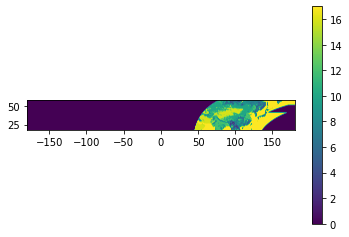

In [16]:
#geodata.Mask.show(china.layers['modis'])
show(china.layers['modis'])

In [17]:
#china.remove_layer('modis')
china.add_layer('MODIS_China.tif', layer_name = 'modis', trim_raster = True)

INFO:geodata.mask:Raster MODIS_China.tif has been reprojected to lat-lon CRS.
INFO:geodata.mask:Layer modis added to the mask China.


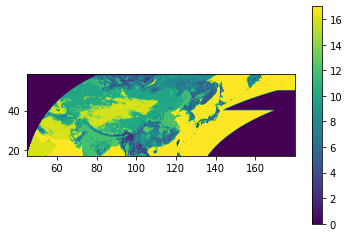

In [18]:
show(china.layers['modis'])

We can also **arbitrary** crop a raster/layer: method `crop_layer` can take either starting indices of top/left, ending indices of right/bottom, or coordinates values in lat/long to trim the raster.

We also have a class method `crop_raster` similar to `crop_layer` but we can have any raster as input, which indicates that users do not necessarily need to add a raster as a layer to call that method. (Similar method: `trim_layer`/`trim_raster`, `binarize_layer`/`binarize_raster`)

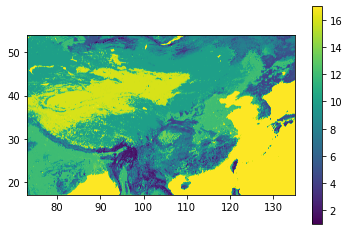

In [19]:
china.crop_layer('modis', bounds = (73, 17, 135, 54))
#same thing with: china.layers['modis'] = geodata.Mask.crop_raster(china.layers['modis'], (73, 17, 135, 54)) #similar to 5bins
show(china.layers['modis'])

### Categorical Value Extraction, if necessary

However, the modis layer have 17 different categorical values, we may want to create a layer of binary values, indicating 0 = unavailable land, and 1 = available land. 

We may not need to worry about this for continous variable/layers.

Values 1, 2, 3, 4, 5 are 5 types of forest for the modis layer, let us use method `binarize_raster` to create a layer of `modis_forest` mask with 1 and 0. 1, 2, 3, 4, 5 will be unavailable land, therefore we need to take in the rest of the values to make them 1 (available).



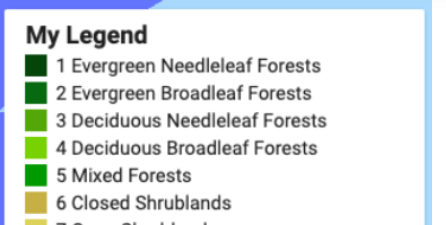

In [20]:
values = np.arange(6, 18)
values

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [21]:
china.layers['modis_forest'] = geodata.Mask.binarize_raster(china.layers['modis'], values = values)
china.remove_layer('modis')

## MERGING FLATTENING LAYERS

Let us check all the layers

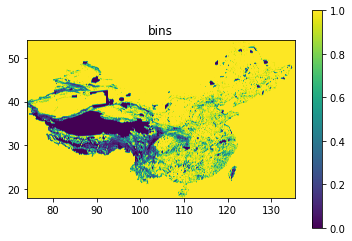

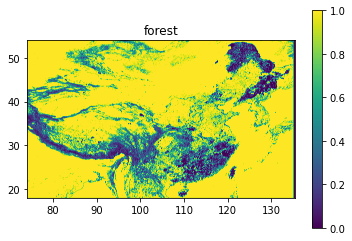

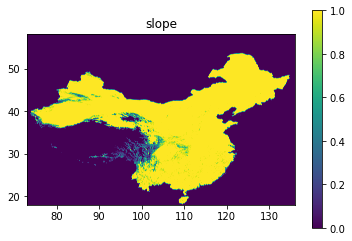

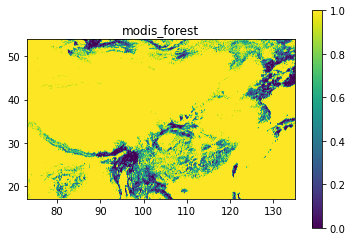

In [22]:
geodata.Mask.show_all(china.layers)

#### (binary) AND method

By default, the `merge_layer` method will use a binary `and` method: if any of the 4 grid cells of the 4 layers at the same location have 0, then the returned `self.merged_layer` will also have 0 at that location. Therefore, if all the layers indicate that a land is not unavailable (!=0), the merged result will have value 1. The `attribute_save` option is by default true, and if it is true, we will save the merged/flattened layers to a object attribute `merged_layer` which can be saved later.

`merge_layer` may also take in an optional parameter `layers`, which is a list of layer names stored in the object. If users do not wish to create the final merged mask with all the layers without deleting unnecessary masks, they may specify which layers to use.

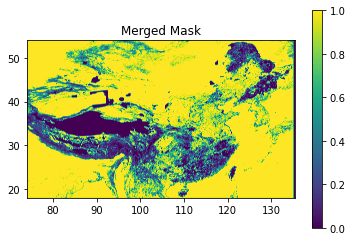

<open DatasetReader name='/vsimem/1a8568f0-3d0b-4c3b-a08a-0df4bfaa5d1a/1a8568f0-3d0b-4c3b-a08a-0df4bfaa5d1a.tif' mode='r'>

In [23]:
china.merge_layer(attribute_save = False, layers = ['bins', 'forest'])

#### sum method

The sum method will add up the values from all the layers. We can also customize the weights.

Behind the scene of the `sum` method: it multiplys each layers with the corresponding weight, and add the in-memory temporary layers together

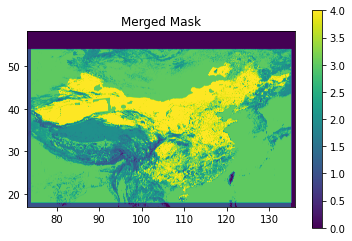

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


In [24]:
china.merge_layer(method = 'sum')

bins: 5%, forest: 25%, slope 40%, and modis_forest 30%. This distribution is completely arbitrary for the purpose of demonstration of the module

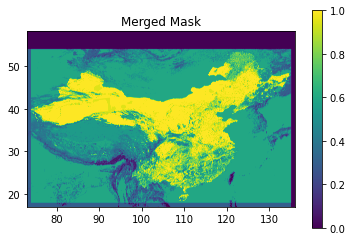

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


In [25]:
china.merge_layer(method = 'sum', weights = {
    'bins': 0.05,
    'forest': 0.25,
    'slope': 0.4,
    'modis_forest': 0.3
})

The result mask use the grid cell resolution with the layer with the **finest resolution**. We can also trim the border of the merged mask since not 4 layers have the same boundary, and the border values are not useful. We can set the parameter `trim` to be `True`.

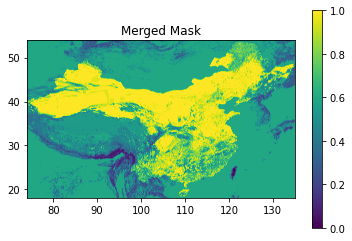

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


In [26]:
china.merge_layer(method = 'sum', weights = {
    'bins': 0.05, 'forest': 0.25, 'slope': 0.4, 'modis_forest': 0.3
}, trim = True)

## LOADING SHAPES, EXTRACTING SHAPE FROM MASK

Let us get provinces shapes from https://scitools.org.uk/cartopy/docs/v0.15/tutorials/using_the_shapereader.html to save the path as a string `prov_path`, this can also be the path to any shape files users have.

In [27]:
import cartopy.io.shapereader as shpreader

In [28]:
prov_path = shpreader.natural_earth(resolution='10m', category='cultural', name = 'admin_1_states_provinces')
prov_path

'C:\\Users\\fengj\\.local\\share\\cartopy\\shapefiles\\natural_earth\\cultural\\ne_10m_admin_1_states_provinces.shp'

Check attributes in the shapes contained in path `prov_path`

In [29]:
#geodata.Mask.shape_attribute(prov_path)

Check out the get_shape() method

In [47]:
geodata.Mask.get_shape?

In [31]:
china_all_shapes = geodata.Mask.get_shape(prov_path, key = 'name_en', 
                         condition_key = 'admin', condition_value = 'China')
china_all_shapes

,name_en,shapes
0,Xinjiang,"POLYGON ((77.88313195800004 35.43106842000005,..."
1,Tibet,"POLYGON ((78.91769413200012 33.38625783300004,..."
2,Inner Mongolia,"POLYGON ((115.9145056560001 47.68391225200013,..."
3,Gansu,"POLYGON ((96.36633990096561 42.72292261928345,..."
4,Yunnan,"POLYGON ((101.8679211830001 22.37884185800006,..."
5,Heilongjiang,"POLYGON ((123.2773120530001 53.56944447900007,..."
6,Jilin,"POLYGON ((131.2528484626863 43.46916859125747,..."
7,Liaoning,(POLYGON ((125.7040896919857 40.85919462483207...
8,Guangxi Zhuang Autonomous Region,(POLYGON ((105.6649503990001 23.04337493900003...
9,Guangdong,"(POLYGON ((114.183035116 22.55619537400004, 11..."


We can also ignore condition, just take three provinces of China by naming them out

In [32]:
china_shapes = geodata.Mask.get_shape(prov_path, key = 'name_en', 
                         targets = ['Jiangsu', 'Zhejiang', 'Shanghai'],
                         return_dict = True)
china_shapes

{'Zhejiang': <shapely.geometry.multipolygon.MultiPolygon at 0x1e6815419d0>,
 'Shanghai': <shapely.geometry.multipolygon.MultiPolygon at 0x1e681541670>,
 'Jiangsu': <shapely.geometry.multipolygon.MultiPolygon at 0x1e681541a60>}

Extract the shapes from the merged_mask:

In [33]:
china.extract_shapes(china_shapes, crop = True)

INFO:geodata.mask:Shape Zhejiang added to attribute 'shape_mask'.
INFO:geodata.mask:Shape Shanghai added to attribute 'shape_mask'.
INFO:geodata.mask:Shape Jiangsu added to attribute 'shape_mask'.


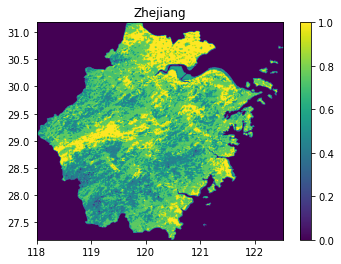

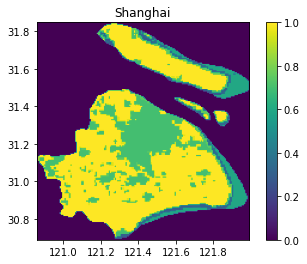

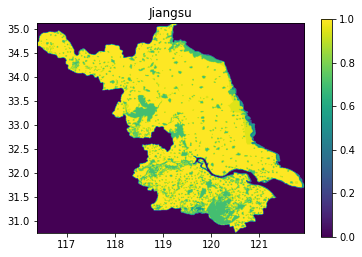

In [34]:
geodata.Mask.show_all(china.shape_mask)

In [35]:
china

Mask China: 
4 layers: ['bins', 'forest', 'slope', 'modis_forest'] .
Merged_mask merged/flattened. 
3 shape_mask: ['Zhejiang', 'Shanghai', 'Jiangsu']. 
Mask has not been saved/updated. 

## SHAPE AS LAYER

This is different from shape extractions, as we will simply treat one shp file as a layer, instead of grabbing the merged mask within that shape.

The `add_shape_layer` method take in a dictionary of shapes, a resolution of the result raster with that shape.

INFO:geodata.mask:Layer Jiangsu added to the mask China.


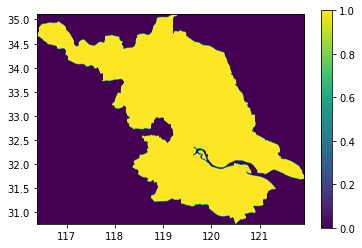

In [36]:
china.add_shape_layer({'Jiangsu': china_shapes['Jiangsu']}, 
                      resolution = (5000, 5000))
show(china.layers['Jiangsu'])

This method is great when we do not have any layers in the mask object at all. However, since we already have bins, forest, and slope... as the layers, we may want to make the shape layers the similar resolution, and similar boundary with the other layers. We can just specify a `reference_layer` in the method call. We can set it to a layer name in the mask, and the result layer resolution and bounds of the shape layer will be same with that specified layer in the mask object.

INFO:geodata.mask:Layer Zhejiang added to the mask China.
INFO:geodata.mask:Layer Shanghai added to the mask China.
INFO:geodata.mask:Layer Jiangsu added to the mask China.


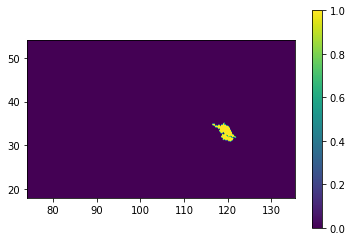

In [37]:
china.add_shape_layer(china_shapes, 
                      reference_layer = 'bins')
show(china.layers['Jiangsu'])

## SAVING MASK

In [38]:
china.save_mask()

INFO:geodata.mask:Mask China successfully saved at D:/Users/davison_lab_data/masks


Note that since "Mask has been saved", we can now load the layers or shapes with xarray.

In [39]:
shape_xr_lst = china.load_shape_xr()
shape_xr_lst['Zhejiang']

<xarray.DataArray (band: 1, y: 628, x: 713)>
[447764 values with dtype=float64]
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 31.18 31.17 31.16 31.16 31.15 ... 27.2 27.2 27.19 27.19
  * x        (x) float64 118.0 118.0 118.0 118.0 ... 122.5 122.5 122.5 122.5
Attributes:
    transform:      (0.006363926718366056, 0.0, 117.99382326168467, 0.0, -0.0...
    crs:            +init=epsg:4326
    res:            (0.006363926718366056, 0.006364039220827179)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

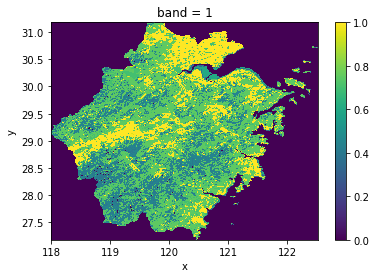

In [40]:
shape_xr_lst['Zhejiang'].plot()

### Load a previously saved Mask



In [41]:
china_2 = geodata.Mask.load_mask("china")

INFO:geodata.mask:Layer bins loaded to the mask china.
INFO:geodata.mask:Layer forest loaded to the mask china.
INFO:geodata.mask:Layer Jiangsu loaded to the mask china.
INFO:geodata.mask:Layer modis_forest loaded to the mask china.
INFO:geodata.mask:Layer Shanghai loaded to the mask china.
INFO:geodata.mask:Layer slope loaded to the mask china.
INFO:geodata.mask:Layer Zhejiang loaded to the mask china.
INFO:geodata.mask:Merged_mask loaded to the mask china.
INFO:geodata.mask:Shape mask Jiangsu loaded to the mask china.
INFO:geodata.mask:Shape mask Shanghai loaded to the mask china.
INFO:geodata.mask:Shape mask Zhejiang loaded to the mask china.


In [42]:
china_2

Mask china: 
7 layers: ['bins', 'forest', 'Jiangsu', 'modis_forest', 'Shanghai', 'slope', 'Zhejiang'] .
Merged_mask merged/flattened. 
3 shape_mask: ['Jiangsu', 'Shanghai', 'Zhejiang']. 
Mask has been saved. 

========= End of the mask module functionality demo =========

Below are some demo that shows some possible errors when there are multiple mask object reading same files. These are not relavant to the demonstration of functions

Note: If you create another object `china_2` that opens the raster `china` is accessing, and then try to save the original `china` without using `china_2.close_files()`, you should expect an error because Python does not want you to rewrite a file that is used by another program. Therefore, `china_2.close_files()` make sures that only `china` mask is having access to the files. `close_files()` will close all the layers in china_2 and make that mask object un-savable. Therefore, it is best to avoid having multiple mask objects accessing the same files.

In [43]:
#expected error
china.save_mask()

CPLE_AppDefinedError: Deleting D:/Users/davison_lab_data/masks/China/layers/bins.tif failed: Permission denied

### Restart kernel here

In [ ]:
import geodata
import logging
logging.basicConfig(level=logging.INFO)

For the codes below, if you comment out the third line, the error is expected.

In [ ]:
china = geodata.Mask.load_mask("china")
china_2 = geodata.Mask.load_mask("china")
china_2.close_files()
china.save_mask()